__Нейросетевая языковая модель на основе схемы Seq2Seq__

Евгений Борисов <esborisov@sevsu.ru>

---

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [3]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [4]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
# !pip install torch

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
# !pip install torchtext

In [9]:
# import torchtext
# from torchtext.data import get_tokenizer

In [10]:
seq_len = 5

In [13]:
class SeqDataset(Dataset):
    
    def __init__(self, text, seq_len=seq_len ):
        assert seq_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._seq_len = seq_len # количество слов контекста слева 
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._seq_len*2 ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._seq_len*2 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else self._tokens['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return (
            self._data[idx,:seq_len],
            self._data[idx,seq_len:],
            # self._num2vec( self._data[idx,-1]) # выход модели - номер слова 
        )
    
    def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
        return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
    
    @property
    def sentence_len(self): return self._seq_len

In [14]:
ds = SeqDataset( text=text, seq_len=seq_len )

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/3754 [00:00<?, ?it/s]

  0%|          | 0/69399 [00:00<?, ?it/s]

In [15]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

69399

3754

24068

24067

In [16]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [18]:
# ds[1]

# модель

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim=128, hidden_dim=256,): 
        super(Encoder, self).__init__()
        self._emb = nn.Embedding(vocab_len, embedding_dim)
        self._gru = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )

    def forward(self, x):
        o = self._emb(x)
        o, h = self._gru(o)
        return o,h

In [21]:
# embedding_dim = 128
# encoder_hidden_dim = 256

# model_encoder = Encoder(
#         vocab_len=len(ds.vocabulary),
#         embedding_dim=embedding_dim,
#         hidden_dim=encoder_hidden_dim,
#     )

# x,y = ds[2]
# print(x.shape)
# with torch.set_grad_enabled(False):  
#     o,h = model_encoder( x )
#     print(o.shape,h.shape)

In [22]:
# ds[:2]

In [23]:
# torch.empty(3, 1, dtype=torch.long).fill_(0)
# torch.zeros(3, 1, dtype=torch.long)

In [24]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_dim, output_size, seq_len):
        super(Decoder, self).__init__()
        self._emb = nn.Embedding(num_embeddings=output_size, embedding_dim=hidden_dim)
        self._gru = nn.GRU( 
                input_size=hidden_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_dim, out_features=output_size, bias=True,)
        self._seq_len = seq_len

        
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        device = next(self._lin.parameters()).device
        batch_size = encoder_outputs.size(0)
        
        # decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(0)
        decoder_input = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(self._seq_len):
            decoder_output, decoder_hidden  = self._forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:,i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach() # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

#     def forward(self, encoder_hidden, target_tensor=None):
#         device = next(self._lin.parameters()).device
#         x = torch.zeros(1, 1, dtype=torch.long, device=device)
#         return self._forward_step(x,encoder_hidden)

    def _forward_step(self,x,h):
        o = self._emb(x)
        o,h = self._gru(o,h)
        o = self._lin(o)
        return o,h

In [25]:
# layer = nn.Linear(in_features=5, out_features=3, bias=True,)
# next(layer.parameters()).device

-----

In [26]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [27]:
embedding_dim = 128
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocab_len=len(ds.vocabulary),
        embedding_dim=embedding_dim,
        hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = Decoder( 
        hidden_dim=encoder_hidden_dim, 
        output_size=len(ds.vocabulary), 
        seq_len=seq_len,
        # device=device,
    ).to(device)

----

In [28]:
# torch.swapaxes(,0,1)

In [29]:
# hidden_dim = 256
# d = torch.zeros((1,2,hidden_dim), device=device)
# layer = nn.GRU( input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1,  batch_first=True,).to(device)

# x,y = ds[:2]
# display( (x.shape,y.shape) ) 

# with torch.set_grad_enabled(False):  
#     o,h = model_encoder(x.to(device))
#     h = torch.swapaxes(h,0,1)
#     display(( o.shape,h.shape) )
#     # layer(d,h)
#     o,h,p = model_decoder(h)

----

In [30]:
from torch import optim

learning_rate = 1e-2
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [31]:
# with torch.set_grad_enabled(False):
#     for input_tensor, target_tensor in DataLoader( ds, batch_size=3, shuffle=True): 
#         encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
#         decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
#         break

# decoder_outputs

# encoder_outputs
# encoder_hidden

In [32]:
# история значений ф-ции потери
loss_history = [] 

In [33]:
from torch.utils.data import DataLoader

In [34]:
%%time

n_epoch = 32 # количество эпох обучения
batch_size = 1024*8

# lag_val_check = 4
# n_iter_no_check = n_epoch*0.33
# assert n_iter_no_check>lag_val_check

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for input_tensor, target_tensor in DataLoader( ds, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 2min, sys: 143 ms, total: 2min
Wall time: 1min 56s


Text(0.5, 1.0, 'min loss: 0.29767')

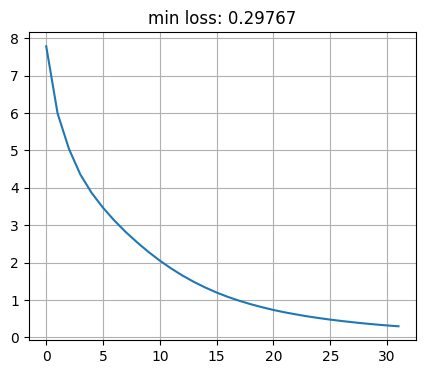

In [35]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

In [ ]:
# # история изменения значений ф-ции потери
# plt.plot(loss_history,label='loss min=%.3f'%(min(loss_history_train)),c='r')
# plt.grid()
# plt.title('история изменения значений ф-ции потери')
# plt.legend()

# тестируем

In [101]:
from random import sample
from nltk.util import ngrams 

prompts = [
    ' '.join(ng) 
    for s in sample( ds.sentences,10 ) if len(s)>ds.sentence_len*2
    for ng in list(ngrams(s[:ds.sentence_len],5))  
    ]

display( prompts )

['Я попробовал переждать , пропустить',
 'Раньше , чем через десять',
 'Несколько дней держался я подальше',
 'Счетчик показывал 1.85 , я',
 '-- Арендую , -- сказал',
 'Я так спешу , я',
 'Но я уже выскочил из',
 'Он было обыкновенным чиновником ,',
 'Тот , кто откажется взять',
 'Больше Пьер в кино не']

In [102]:
class LangModelSeq2Seq: # генератор текста 
    
    def __init__(self,encoder,decoder,vocabulary):
        self._encoder = encoder 
        self._decoder = decoder 
        self._vocabulary = vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,n_iter=1):
        eos = self._vocabulary['<EOS>']
        x = self._encode(prompt) # начальная последовательность токенов
        codes = []
        for _ in range(n_iter):
            p = self._predict(x) # генерируем следующий токен
            codes.append(p)
            if (p==eos).any():break
            x = torch.tensor(p.reshape(1,-1,),dtype=torch.long)
            #print(x)
        return self._strip_eos( self._decode(np.hstack(codes)) ) # конвертируем коды токенов в строку

    def _predict(self,x):
        device = next(self._encoder.parameters()).device 
        with torch.set_grad_enabled(False): # генерируем следующий токен
            o, h = self._encoder(x.to(device))
            o,_,_ = self._decoder(o,h)
        return np.argmax( o.cpu().numpy()[0],axis=1) 
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])
    @staticmethod
    def _strip_eos(s,eos='<EOS>'):
        n = s.find(eos)
        return s if n<0 else s[:n+len(eos)]

In [104]:
for prompt in prompts:
    t = LangModelSeq2Seq(model_encoder,model_decoder,ds.vocabulary).predict(prompt,n_iter=25)
    print(prompt,'==>', t,'\n')

Я попробовал переждать , пропустить ==> конкурентов , куда там : желтые машины летели непрерывным потоком , что было делать со вздохом : -- Я не знаю , что я `` хороший парень '' . <EOS> 

Раньше , чем через десять ==> минут я не попаду в этой паскудной Америке ? <EOS> 

Несколько дней держался я подальше ==> от идиотской этой гостиницы , объезжал ее , что называется , десятой дорогой , но как-то раз пришлось мне высадить клиента возле дома напротив `` Мэдисона '' , и про то , как и в конце концов привела меня на станцию , с которой отправился мой поезд в будущее , мне придется , передохнув малость после первой части `` Желтых королей '' ( это книга '' Водители '' , которую я тоже не сразу раскусил с ней , как `` эй-мен '' опустил стекло и зовет : -- Садись , вот когда ты ответишь , что новый кэб тебе ни к чему ; вполне сгодится , но он навсегда остался частицей той страны . <EOS> 

Счетчик показывал 1.85 , я ==> с натугой выдавил из себя : -- А решение судьи по такому делу может повли

----

In [ ]:
#     loss_batch = []
#     with torch.set_grad_enabled(False):   
#         # получаем батч проверочных примеров
#         for input_tensor, target_tensor in DataLoader( ds_val, batch_size=batch_size, shuffle=False): 
#             encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
#             decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
#             loss = criterion(
#                 decoder_outputs.view(-1, decoder_outputs.size(-1)),
#                 target_tensor.to(device).view(-1)
#             )
#             loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче

#     loss_history_val.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

#     if i>n_iter_no_check:
#         if ( loss_history_val[-lag_val_check]<loss_history_val[-1] ):
#             print( 'validation loss value up, stoped\n' )
#             break

In [ ]:
# %%time 

# init_seq = []
# hypothesis = []
# reference = []

# with torch.set_grad_enabled(False):
#     for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=False): 
#         encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
#         decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
#         init_seq.append( input_tensor.cpu().numpy() )
        
#         reference.append( target_tensor.cpu().numpy() )
        
#         hypothesis.append( 
#             np.swapaxes(np.argmax(
#                 decoder_outputs.cpu().numpy()
#                 ,axis=-1,keepdims=True),2,1)
#         )

# init_seq = np.vstack( init_seq )        
# reference = np.vstack( reference )
# hypothesis = np.vstack( hypothesis )

# display( init_seq.shape, reference.shape, hypothesis.shape, )

# df_train_  = pd.DataFrame({
#         'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
#         'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
#         'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
#     })

# display( df_train_.sample(17) )

In [98]:
# def encode(s): # кодируем строку
#     s = nltk_tokenize_word(s,language='russian')
#     s = [ ds.vocabulary[w] for w in s if (w in ds.vocabulary) ]
#     return torch.tensor([s], dtype=torch.long )

# prompt = prompts[0]
# display(prompt)

# x = encode(prompt)
# display(x)

In [99]:
# with torch.set_grad_enabled(False):
#     encoder_outputs, encoder_hidden = model_encoder(x.to(device))
#     decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden) #, target_tensor.to(device))        

In [100]:
# vocabulary_inv = { v:k for k,v in ds.vocabulary.items() }

# def decode(codes): # конвертируем коды токенов в строку
#     return ' '.join([ 
#         vocabulary_inv[c] 
#         for c in codes if (c in vocabulary_inv) 
#     ])

# codes = np.argmax( decoder_outputs.cpu().numpy()[0],axis=1) #.shape 
# decode(codes)